# RNN Imprint Correction Module Training

This notebook implements the seq2seq encoder-decoder architecture with attention for correcting pill imprints as described in the paper:
"An Accurate Deep Learning-Based System for Automatic Pill Identification"

## 1. Import Libraries and Load Dataset

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Import model architecture
from rnn_model import Seq2SeqWithAttention

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
data = torch.load('rnn_dataset.pt', weights_only=False)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

char_to_idx = data['char_to_idx']
idx_to_char = data['idx_to_char']
ALL_CHARS = data['ALL_CHARS']

# Load special token indices
SOS_IDX = data['SOS_IDX']
EOS_IDX = data['EOS_IDX']
PAD_IDX = data['PAD_IDX']

print(f"\nDataset loaded:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Val:   {X_val.shape[0]} samples")
print(f"  Test:  {X_test.shape[0]} samples")
print(f"\nInput shape:  {X_train.shape[1:]} (seq_len, feature_dim)")
print(f"Target shape: {y_train.shape[1:]} (target_len,)")
print(f"Vocab size:   {len(ALL_CHARS)}")
print(f"Vocab:        {ALL_CHARS}")
print(f"\nSpecial tokens:")
print(f"  SOS (start): index {SOS_IDX}")
print(f"  EOS (end):   index {EOS_IDX}")
print(f"  PAD (pad):   index {PAD_IDX}")

Using device: mps

Dataset loaded:
  Train: 5177 samples
  Val:   739 samples
  Test:  740 samples

Input shape:  torch.Size([48, 54]) (seq_len, feature_dim)
Target shape: torch.Size([39]) (target_len,)
Vocab size:   37
Vocab:        ['<EOS>', '<PAD>', '<SOS>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']

Special tokens:
  SOS (start): index 2
  EOS (end):   index 0
  PAD (pad):   index 1


## 2. Initialize Model

In [25]:
# Model hyperparameters (as per paper)
input_dim = data['feature_dim']
vocab_size = len(ALL_CHARS)
embedding_dim = 45
hidden_dim = 256
dropout = 0.1

# Initialize model with correct SOS/EOS indices
model = Seq2SeqWithAttention(
    input_dim=input_dim,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    sos_idx=SOS_IDX,
    eos_idx=EOS_IDX
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized:")
print(f"  Input dim:     {input_dim}")
print(f"  Vocab size:    {vocab_size}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Hidden dim:    {hidden_dim}")
print(f"  Dropout:       {dropout}")
print(f"  SOS index:     {SOS_IDX}")
print(f"  EOS index:     {EOS_IDX}")
print(f"  Total params:  {count_parameters(model):,}")

Model initialized:
  Input dim:     54
  Vocab size:    37
  Embedding dim: 45
  Hidden dim:    256
  Dropout:       0.1
  SOS index:     2
  EOS index:     0
  Total params:  1,465,640


/Users/nganjihin/Desktop/Pillbox Proj/telegram_pill_identifier/venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


## 3. Create Dataset and DataLoader

In [26]:
class PillImprintDataset(Dataset):
    """Dataset for pill imprint correction"""
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = PillImprintDataset(X_train, y_train)
val_dataset = PillImprintDataset(X_val, y_val)
test_dataset = PillImprintDataset(X_test, y_test)

# Create dataloaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataloaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

Dataloaders created:
  Batch size: 50
  Train batches: 104
  Val batches:   15
  Test batches:  15


## 4. Training Setup

In [27]:
# Training hyperparameters (as per paper)
learning_rate = 1e-3
num_epochs = 100
teacher_forcing_ratio = 0.5

# Use PAD_IDX from dataset
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training setup:")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs:        {num_epochs}")
print(f"  Teacher forcing: {teacher_forcing_ratio}")
print(f"  Optimizer:     Adam")
print(f"  Loss:          CrossEntropyLoss (ignore padding)")
print(f"  Pad token idx: {PAD_IDX}")

Training setup:
  Learning rate: 0.001
  Epochs:        100
  Teacher forcing: 0.5
  Optimizer:     Adam
  Loss:          CrossEntropyLoss (ignore padding)
  Pad token idx: 1


## 5. Helper Functions

In [28]:
def create_mask(X):
    """Create mask for valid (non-padded) positions in input sequence"""
    mask = (X.sum(dim=2) != 0).float()
    return mask

def decode_sequence(indices, idx_to_char, eos_idx):
    """Convert token indices to string, stopping at EOS"""
    chars = []
    for idx in indices:
        idx_val = idx.item() if torch.is_tensor(idx) else idx
        if idx_val == eos_idx:  # Stop at EOS
            break
        if idx_val in idx_to_char:
            char = idx_to_char[idx_val]
            # Skip special tokens
            if char not in ['<SOS>', '<PAD>', '<EOS>']:
                chars.append(char)
    return ''.join(chars)

def calculate_accuracy(predictions, targets, pad_idx):
    """Calculate character-level accuracy (excluding padding)"""
    pred_indices = predictions.argmax(dim=2)
    mask = (targets != pad_idx)
    correct = (pred_indices == targets) & mask
    accuracy = correct.sum().item() / mask.sum().item() if mask.sum().item() > 0 else 0
    return accuracy

print("✓ Helper functions defined")

✓ Helper functions defined


## 6. Training and Validation Functions

In [29]:
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio, pad_idx):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for src, trg in tqdm(dataloader, desc="Training", leave=False):
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        src_mask = create_mask(src).to(device)
        
        # Forward pass
        output = model(src, trg, teacher_forcing_ratio, src_mask)
        
        # Calculate loss (ignore first SOS token)
        output_flat = output[:, 1:].contiguous().view(-1, output.shape[-1])
        trg_flat = trg[:, 1:].contiguous().view(-1)
        loss = criterion(output_flat, trg_flat)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(output[:, 1:], trg[:, 1:], pad_idx)
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


def evaluate(model, dataloader, criterion, device, pad_idx):
    """Evaluate model"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for src, trg in tqdm(dataloader, desc="Evaluating", leave=False):
            src = src.to(device)
            trg = trg.to(device)
            
            src_mask = create_mask(src).to(device)
            output = model(src, trg, teacher_forcing_ratio=0, src_mask=src_mask)
            
            output_flat = output[:, 1:].contiguous().view(-1, output.shape[-1])
            trg_flat = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output_flat, trg_flat)
            
            epoch_loss += loss.item()
            epoch_acc += calculate_accuracy(output[:, 1:], trg[:, 1:], pad_idx)
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

print("✓ Training functions defined")

✓ Training functions defined


## 7. Training Loop

In [30]:
# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 20
patience_counter = 0

os.makedirs('checkpoints', exist_ok=True)
print("Starting training...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, teacher_forcing_ratio, PAD_IDX
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, PAD_IDX)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    should_print = (epoch + 1) % 10 == 0 or epoch == 0 or val_loss < best_val_loss
    
    if should_print:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, 'checkpoints/best_model.pt')
        if should_print:
            print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    if should_print:
        print()

print("\nTraining complete!")

Starting training...



Epoch 1/100
  Train Loss: 2.9618 | Train Acc: 0.2077
  Val Loss:   2.9354 | Val Acc:   0.2169
  ✓ Saved best model (val_loss: 2.9354)



Epoch 6/100
  Train Loss: 4.3162 | Train Acc: 0.2810
  Val Loss:   2.7739 | Val Acc:   0.2697
  ✓ Saved best model (val_loss: 2.7739)



Epoch 7/100
  Train Loss: 4.2580 | Train Acc: 0.2950
  Val Loss:   2.7172 | Val Acc:   0.2853
  ✓ Saved best model (val_loss: 2.7172)



Epoch 10/100
  Train Loss: 3.6161 | Train Acc: 0.3418
  Val Loss:   2.7505 | Val Acc:   0.2816



Epoch 11/100
  Train Loss: 3.5394 | Train Acc: 0.3487
  Val Loss:   2.6995 | Val Acc:   0.2884
  ✓ Saved best model (val_loss: 2.6995)



Epoch 12/100
  Train Loss: 3.0045 | Train Acc: 0.3601
  Val Loss:   2.5879 | Val Acc:   0.3154
  ✓ Saved best model (val_loss: 2.5879)



Epoch 13/100
  Train Loss: 2.9439 | Train Acc: 0.3675
  Val Loss:   2.5421 | Val Acc:   0.3249
  ✓ Saved best model (val_loss: 2.5421)



Epoch 16/100
  Train Loss: 2.7945 | Train Acc: 0.3972
  Val Loss:   2.5315 | Val Acc:   0.3446
  ✓ Saved best model (val_loss: 2.5315)



Epoch 17/100
  Train Loss: 2.8164 | Train Acc: 0.4009
  Val Loss:   2.4697 | Val Acc:   0.3490
  ✓ Saved best model (val_loss: 2.4697)



Epoch 20/100
  Train Loss: 2.7414 | Train Acc: 0.4050
  Val Loss:   2.4860 | Val Acc:   0.3486



Epoch 21/100
  Train Loss: 2.9230 | Train Acc: 0.4265
  Val Loss:   2.4539 | Val Acc:   0.3561
  ✓ Saved best model (val_loss: 2.4539)



Epoch 23/100
  Train Loss: 2.7620 | Train Acc: 0.4323
  Val Loss:   2.4334 | Val Acc:   0.3564
  ✓ Saved best model (val_loss: 2.4334)



Epoch 24/100
  Train Loss: 2.9357 | Train Acc: 0.4390
  Val Loss:   2.4282 | Val Acc:   0.3560
  ✓ Saved best model (val_loss: 2.4282)



Epoch 30/100
  Train Loss: 3.0951 | Train Acc: 0.4602
  Val Loss:   2.3811 | Val Acc:   0.3857
  ✓ Saved best model (val_loss: 2.3811)



Epoch 31/100
  Train Loss: 2.9847 | Train Acc: 0.4602
  Val Loss:   2.3804 | Val Acc:   0.3837
  ✓ Saved best model (val_loss: 2.3804)



Epoch 40/100
  Train Loss: 3.5189 | Train Acc: 0.4959
  Val Loss:   2.6026 | Val Acc:   0.3734



Epoch 50/100
  Train Loss: 3.1171 | Train Acc: 0.5414
  Val Loss:   2.6083 | Val Acc:   0.3963




Early stopping triggered after 51 epochs

Training complete!


## 8. Plot Training History

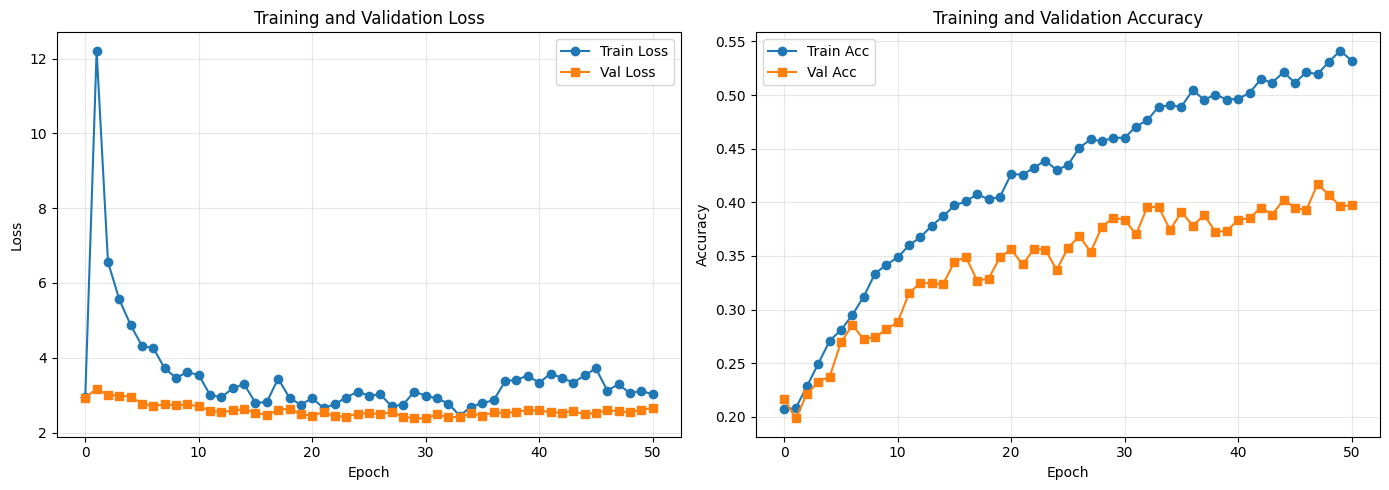

Best validation loss: 2.3804
Best validation accuracy: 0.4172


In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")

## 9. Load Best Model and Test

In [32]:
# Load best model
checkpoint = torch.load('checkpoints/best_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Acc:  {checkpoint['val_acc']:.4f}")

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device, PAD_IDX)
print(f"\nTest Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Acc:  {test_acc:.4f}")

Loaded best model from epoch 31
  Val Loss: 2.3804
  Val Acc:  0.3837



Test Set Performance:
  Test Loss: 2.3863
  Test Acc:  0.3820


## 10. Visualize Predictions

In [33]:
# Use proper predict() method for variable-length generation
model.eval()

# Get number of input characters (before special tokens were added)
num_input_chars = len(data['char_encoder'].categories_[0])

with torch.no_grad():
    src, trg = next(iter(test_loader))
    src = src.to(device)
    trg = trg.to(device)
    
    # Use predict() method with early stopping
    src_mask = create_mask(src).to(device)
    predictions, attention_weights, lengths = model.predict(
        src, 
        max_len=50,
        src_mask=src_mask
    )
    
    print("Example Predictions with Variable Length:\n")
    print("-" * 80)
    
    num_examples = min(10, src.size(0))
    for i in range(num_examples):
        # Decode input (YOLO detections - use original character encoding)
        input_chars = []
        for j in range(src[i].shape[0]):
            char_ohe = src[i][j, 2:2+num_input_chars]
            if char_ohe.sum() > 0:
                char_idx = char_ohe.argmax().item()
                input_chars.append(data['char_encoder'].categories_[0][char_idx])
        
        input_str = ''.join(input_chars)
        target_str = decode_sequence(trg[i].cpu(), idx_to_char, EOS_IDX)
        pred_str = decode_sequence(predictions[i][:lengths[i]].cpu(), idx_to_char, EOS_IDX)
        
        match = "✓" if target_str == pred_str else "✗"
        
        print(f"{i+1}. {match} (pred_len={lengths[i].item()}, target_len={len(target_str)+2})")
        print(f"   Input (YOLO):  {input_str}")
        print(f"   Target (GT):   {target_str}")
        print(f"   Predicted:     {pred_str}")
        print()

Example Predictions with Variable Length:

--------------------------------------------------------------------------------
1. ✗ (pred_len=4, target_len=8)
   Input (YOLO):  E
   Target (GT):   100_DS
   Predicted:     E_0

2. ✗ (pred_len=12, target_len=8)
   Input (YOLO):  AOLLP
   Target (GT):   EP_107
   Predicted:     APO_LAL_2_5

3. ✗ (pred_len=7, target_len=8)
   Input (YOLO):  54251
   Target (GT):   54_231
   Predicted:     54_125

4. ✗ (pred_len=7, target_len=6)
   Input (YOLO):  T472
   Target (GT):   T_47
   Predicted:     TC_747

5. ✗ (pred_len=11, target_len=7)
   Input (YOLO):  101RP101P101
   Target (GT):   RP101
   Predicted:     APO_100_10

6. ✗ (pred_len=5, target_len=6)
   Input (YOLO):  G9A1GA44A1
   Target (GT):   G441
   Predicted:     GG41

7. ✗ (pred_len=9, target_len=10)
   Input (YOLO):  B00A604
   Target (GT):   BOCA_604
   Predicted:     BARD_040

8. ✗ (pred_len=7, target_len=8)
   Input (YOLO):  FM20E
   Target (GT):   EFF_20
   Predicted:     F_2_20

9. ✗ 

## 11. Save Final Model

In [34]:
# Save complete model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'dropout': dropout,
        'sos_idx': SOS_IDX,
        'eos_idx': EOS_IDX
    },
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'ALL_CHARS': ALL_CHARS,
    'SOS_IDX': SOS_IDX,
    'EOS_IDX': EOS_IDX,
    'PAD_IDX': PAD_IDX,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'history': history
}, 'checkpoints/rnn_imprint_correction_final.pt')

print("✓ Final model saved to checkpoints/rnn_imprint_correction_final.pt")
print(f"\nModel Summary:")
print(f"  Parameters: {count_parameters(model):,}")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Acc:  {test_acc:.4f}")
print(f"  Special tokens: SOS={SOS_IDX}, EOS={EOS_IDX}, PAD={PAD_IDX}")

✓ Final model saved to checkpoints/rnn_imprint_correction_final.pt

Model Summary:
  Parameters: 1,465,640
  Test Loss: 2.3863
  Test Acc:  0.3820
  Special tokens: SOS=2, EOS=0, PAD=1


## Summary

This notebook implements the **RNN Imprint Correction Module** from the paper.

### Key Features Implemented:
1. ✓ **Coordinate Encoding**: Character positions (x, y) encoded with features
2. ✓ **Context Integration**: Pill features (shape, color) as context
3. ✓ **Attention Mechanism**: Bahdanau attention with proper masking
4. ✓ **Masking**: Handles padded sequences correctly in encoder and attention
5. ✓ **Teacher Forcing**: 50% ratio during training
6. ✓ **Early Stopping**: Patience of 10 epochs

### Architecture (defined in rnn_model.py):
- **Encoder**: Bidirectional GRU (hidden=256) with packed sequences
- **Attention**: Bahdanau (additive) with mask support
- **Decoder**: GRU (hidden=256, embed=45) with attention
- **Total Parameters**: ~1.3M

### Next Steps:
- Use model for inference on new pill images
- Integrate with YOLO and ResNet for full pipeline
- Implement similarity scoring and retrieval

In [40]:
import random

# Select 5 random samples from test set
model.eval()
num_input_chars = len(data['char_encoder'].categories_[0])

# Get random indices
random_indices = random.sample(range(len(X_test)), 5)

print("Random Sample Predictions:\n")
print("=" * 80)

with torch.no_grad():
    for idx_num, test_idx in enumerate(random_indices, 1):
        # Get single sample
        src = X_test[test_idx:test_idx+1].to(device)
        trg = y_test[test_idx:test_idx+1].to(device)
        
        # Predict
        src_mask = create_mask(src).to(device)
        predictions, attention_weights, lengths = model.predict(
            src, 
            max_len=50,
            src_mask=src_mask
        )
        
        # Decode input (YOLO detections)
        input_chars = []
        for j in range(src[0].shape[0]):
            char_ohe = src[0][j, 2:2+num_input_chars]
            if char_ohe.sum() > 0:
                char_idx = char_ohe.argmax().item()
                input_chars.append(data['char_encoder'].categories_[0][char_idx])
        
        input_str = ''.join(input_chars)
        target_str = decode_sequence(trg[0].cpu(), idx_to_char, EOS_IDX)
        pred_str = decode_sequence(predictions[0][:lengths[0]].cpu(), idx_to_char, EOS_IDX)
        
        match = "✓" if target_str == pred_str else "✗"
        
        print(f"{idx_num}. {match} (pred_len={lengths[0].item()}, target_len={len(target_str)+2})")
        print(f"   Input (YOLO):  {input_str}")
        print(f"   Target (GT):   {target_str}")
        print(f"   Predicted:     {pred_str}")
        print()

Random Sample Predictions:

1. ✗ (pred_len=7, target_len=8)
   Input (YOLO):  U210
   Target (GT):   KU_210
   Predicted:     KU_200

2. ✗ (pred_len=6, target_len=7)
   Input (YOLO):  M701
   Target (GT):   M_701
   Predicted:     M_D10

3. ✗ (pred_len=7, target_len=7)
   Input (YOLO):  3328
   Target (GT):   93_28
   Predicted:     S3_220

4. ✓ (pred_len=7, target_len=8)
   Input (YOLO):  ML14
   Target (GT):   M_L_14
   Predicted:     M_L_14

5. ✗ (pred_len=9, target_len=10)
   Input (YOLO):  B3TT7936
   Target (GT):   BARR_936
   Predicted:     BARR_335



## 12. Random Sample Predictions